In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

### 1. Non-IID (dirichlet partition)

In [26]:
data = pd.read_csv("DataAfterPreprocessing.csv")
X = data.iloc[:,:-1].values
y = data.iloc[:,-1].values

In [27]:
# First randomly split train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

In [28]:
# Then Non-IID split the train dataset
def dirichlet_partition(data_label, alpha, user_num):
    index = np.arange(len(data_label))

    index_label = np.vstack((index, data_label))
    index_label = index_label[:, index_label[1,:].argsort()]

    labels = np.unique(data_label, axis=0)
    
    data_dict = data_organize(index_label, labels)
   
    data_partition_profile = {}
    for i in range(user_num):
        data_partition_profile[i] = []

    ## Distribute rest data
    for label in data_dict:
        proportions = np.random.dirichlet(np.repeat(alpha, user_num))
        proportions = len(data_dict[label]) * proportions

        for user in data_partition_profile:
            data_partition_profile[user]   \
                = set.union(set(np.random.choice(data_dict[label], int(proportions[user]) , replace = False)), data_partition_profile[user])
            data_dict[label] = list(set(data_dict[label])-data_partition_profile[user])

        while len(data_dict[label]) != 0:
            rest_data = data_dict[label][0]
            user = np.random.randint(0, user_num)
            data_partition_profile[user].add(rest_data)
            data_dict[label].remove(rest_data)

    for user in data_partition_profile:
        data_partition_profile[user] = list(data_partition_profile[user])
        np.random.shuffle(data_partition_profile[user])

    return data_partition_profile


def data_organize(index_label, labels):
    data_dict = {}

    labels = np.unique(labels, axis=0)
    for one in labels:
        data_dict[one] = []

    for i in range(len(index_label[1, :])):
        data_dict[index_label[1, i]].append(index_label[0, i])
    return data_dict


In [29]:
alpha = 0.5
user_num = 4
partition_result = dirichlet_partition(y_train, alpha, user_num)
result = {}
for user in partition_result:
    X_sub = X_train[partition_result[user], :]
    y_sub = np.array(y_train[partition_result[user]]).reshape((-1,1))
    result[user] = np.hstack((X_sub, y_sub))
# print(result)
# 训练集Non-IID划分的最终结果为result
# result结构:{0:[[matrix]], 1:[[matrix]], 2:[[matrix]], 3:[[matrix]]}；此处0代表user0，以此类推。

First, randomly pick 25% of samples as testing data. Then split the remaining 75% of samples as training data into 4 non-iid subsets for 4 real estate companies. That is we split samples of each category in training dataset into 4 parts according to dirichlet distribution (with alpha 0.5) for 4 companies. 

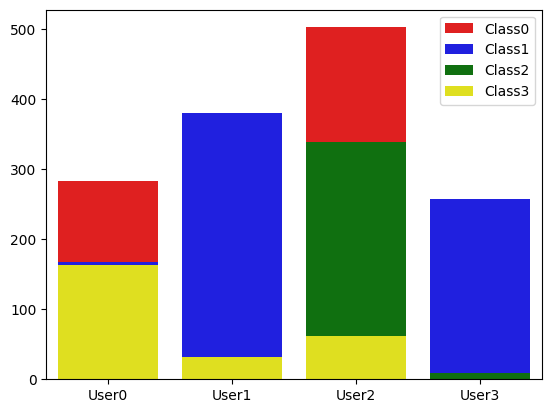

In [24]:
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
describe = {}
for user in result:
    temp = []
    label_count = dict(Counter(result[user][:,-1]))
    for category in label_count:
        temp.append(label_count[category])
    describe[user] = temp
matrix = np.zeros((4,4))
for user in describe:
    for i in range(len(describe[user])):
        matrix[user, i] = describe[user][i]

# Plot sample distribution
sns.barplot(x=["User0","User1","User2","User3"], y=matrix[:,0], label="Class0", color="red")
sns.barplot(x=["User0","User1","User2","User3"], y=matrix[:,1], label="Class1", color="blue")
sns.barplot(x=["User0","User1","User2","User3"], y=matrix[:,2], label="Class2", color="green")
sns.barplot(x=["User0","User1","User2","User3"], y=matrix[:,3], label="Class3", color="yellow")
plt.legend()